In [2]:
# Import Librarys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron as SklearnPerceptron, SGDClassifier
from sklearn.model_selection import GridSearchCV


import gc

In [3]:
# X is features y is prediction (This for me to remember)
# Set pathing for base and validation sets
pa_path = r"C:\Users\andre\OneDrive - University of Arkansas\Desktop\Andrew_Branch_ML\project_adult.csv"
pvi_path = r"C:\Users\andre\OneDrive - University of Arkansas\Desktop\Andrew_Branch_ML\project_validation_inputs.csv"

# Read the files in
pa = pd.read_csv(pa_path)
pvi = pd.read_csv(pvi_path)


In [4]:

def preprocess_data_label(df):
    # Drop unnamed col, don't need
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Handle missing values (simple drop, can be improved later)
    df = df.dropna()

    # Drop rows where any categorical column contains '?'
    df = df[~df.isin(['?']).any(axis=1)]

    # Separate categorical and numeric columns
    cat_cols = df.select_dtypes(include=['object']).columns
    income_col = df['income'].copy()
    cat_cols = cat_cols.drop('income')  # remove target col

    num_cols = df.select_dtypes(exclude=['object']).columns

    # Encode income (target) as ordinal
    income_col = income_col.map({'<=50K': 0, '>50K': 1})

    # Apply LabelEncoder to each categorical column
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    # Encode numerical values
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # Concatenate numeric, categorical, and income
    df = pd.concat([df[num_cols], df[cat_cols], income_col.rename('income')], axis=1)

    X = df.drop(columns=['income'], axis=1)
    y = df[['income']]

    return X.values, y.values.ravel()


def preprocess_data_validation_label(df):
    # Drop unnamed col, don't need
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Handle missing values (simple drop, can be improved later)
    df = df.dropna()

    # Drop rows where any categorical column contains '?'
    df = df[~df.isin(['?']).any(axis=1)]

    # Separate categorical and numeric columns
    cat_cols = df.select_dtypes(include=['object']).columns
    num_cols = df.select_dtypes(exclude=['object']).columns

    # Apply LabelEncoder to each categorical column
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    # Encode numerical values
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # Concatenate numeric + categorical
    df = pd.concat([df[num_cols], df[cat_cols]], axis=1)

    return df.values

In [5]:
def preprocess_data(df):
    # Drop unnamed col, don't need
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Handle missing values (simple drop, can be improved later)
    df = df.dropna()

    # Separate categorical and numeric columns
    cat_cols = df.select_dtypes(include=['object']).columns
    income_col = df['income'].copy()
    cat_cols = cat_cols.drop('income')

    num_cols = df.select_dtypes(exclude=['object']).columns


    # Incode income as ordinal since it is, all other categorical cols are not ordinal they are nominal
    income_col = income_col.map({'<=50K': 0, '>50K': 1})


    # Use of OneHotEncoder over LabelEncoder is since most of the Categorical cols are not ordinal there nominal so it wont make since to use label encoder
    # OneHotEncoder will help in this by breaking out the num of unique values found in the categorical col and break those out into multiple cols
    # Example: the Class col may have Private, Local-gov, or Never-worked values in it. These will get broken out into 3 cols for each unique value for that observation and if it was local-gov for that obervation it will be marked with a 1 and the other two are 0
    # Deciding to keep ? values in cols for workclass, occupation, and native-country since there could be some important pattern info that can come from it
    # the ? values will get encoded, can always fix later if issue

    # Apply OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')
    encoded = ohe.fit_transform(df[cat_cols])

    # Convert encoded array back to DataFrame
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cat_cols), index=df.index)

    # Encode numerical values
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # Concatenate numeric and encoded categorical features
    df = pd.concat([df[num_cols], encoded_df, income_col.rename('income')], axis=1)

    X = df.drop(columns=['income'], axis=1)
    y = df[['income']]


    return X.values, y.values.ravel()

def preprocess_data_validation(df):
    # Drop unnamed col, don't need
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Handle missing values (simple drop, can be improved later)
    df = df.dropna()

    # Separate categorical and numeric columns
    cat_cols = df.select_dtypes(include=['object']).columns
    num_cols = df.select_dtypes(exclude=['object']).columns


    # Use of OneHotEncoder over LabelEncoder is since most of the Categorical cols are not ordinal there nominal so it wont make since to use label encoder
    # OneHotEncoder will help in this by breaking out the num of unique values found in the categorical col and break those out into multiple cols
    # Example: the Class col may have Private, Local-gov, or Never-worked values in it. These will get broken out into 3 cols for each unique value for that observation and if it was local-gov for that obervation it will be marked with a 1 and the other two are 0
    # Deciding to keep ? values in cols for workclass, occupation, and native-country since there could be some important pattern info that can come from it
    # the ? values will get encoded, can always fix later if issue

    # Apply OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')
    encoded = ohe.fit_transform(df[cat_cols])

    # Convert encoded array back to DataFrame
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cat_cols), index=df.index)

    # Encode numerical values
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # Concatenate numeric and encoded categorical features
    df = pd.concat([df[num_cols], encoded_df], axis=1)






    return df.values


In [6]:
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)

        self.errors_ = []


        # best identifiers
        self.best_errors_ = float('inf')
        self.best_w_ = self.w_.copy()
        self.best_b_ = self.b_

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)

            self.errors_.append(errors)

            if errors < self.best_errors_:
                self.best_errors_ = errors
                self.best_w_ = self.w_
                self.best_b_ = self.b_
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [7]:
class AdalineSGD:
    """ADAptive LInear NEuron classifier (stochastic gradient descent).

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset (epochs).
    shuffle : bool (default: True)
      Shuffles training data every epoch to prevent cycles.
    random_state : int
      Random number generator seed for reproducibility.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared error loss function values in each epoch.
    """

    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data."""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.losses_ = []
        self.errors_ = []

        # best identifiers
        self.best_misclassifications_ = float('inf')
        self.best_w_ = self.w_.copy()
        self.best_b_ = self.b_

        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)

            losses = []
            for xi, target in zip(X, y):
                loss = self._update_weights(xi, target)
                losses.append(loss)

            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)

            # count misclassifications at the end of each epoch
            y_pred = self.predict(X)
            misclassifications = (y != y_pred).sum()
            if misclassifications < self.best_misclassifications_:
                self.best_misclassifications_ = misclassifications
                self.best_w_ = self.w_.copy()
                self.best_b_ = self.b_

            self.errors_.append(misclassifications)

        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing weights."""
        if not hasattr(self, "w_"):
            self.rgen = np.random.RandomState(self.random_state)
            self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
            self.b_ = np.float64(0.)

        for xi, target in zip(X, y):
            self._update_weights(xi, target)

        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        idx = self.rgen.permutation(len(y))
        return X[idx], y[idx]

    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to a single sample"""
        net_input = self.net_input(xi)
        output = self.activation(net_input)
        error = target - output
        self.w_ += self.eta * 2.0 * xi * error
        self.b_ += self.eta * 2.0 * error
        loss = (error**2).mean()
        return loss

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [8]:
def net_input(X, w_, b_):
    """Calculate net input"""
    return np.dot(X, w_) + b_

def activation(X):
    """Compute linear activation"""
    return X

def predict_adaline(X, w_, b_):
    """Return class label after unit step"""
    return np.where(net_input(X, w_, b_) >= 0.0, 1, 0)

def predict_perceptron(X, w_, b_):
    """Return class label after unit step"""
    return np.where(net_input(X, w_, b_) >= 0.5, 1, 0)

In [9]:
# Apply preprocessing
X_label, y_label = preprocess_data_label(pa)
X_label_validation = preprocess_data_validation_label(pvi)

X_train, X_test, y_train, y_test = train_test_split(
    X_label, y_label,
    test_size=0.2,       # 20% for testing, 80% for training
    random_state=42,     # ensures reproducibility
    stratify=y_label           # keep class distribution balanced
)

In [10]:
ppn = Perceptron(eta=0.1, n_iter=50, random_state=1).fit(X_label, y_label)
ada = AdalineSGD(eta=0.00001, n_iter=50).fit(X_label, y_label)

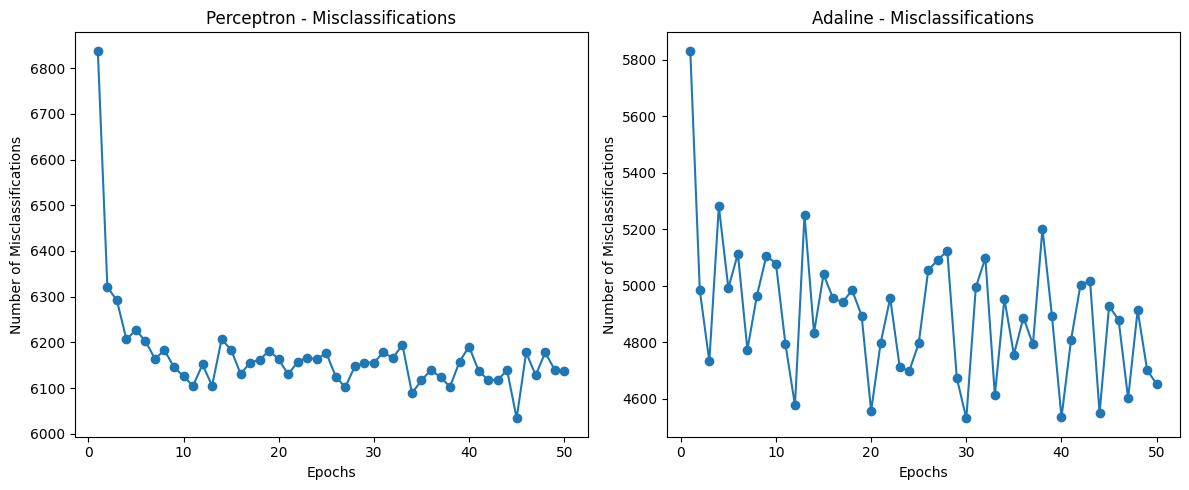

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Perceptron plot
axes[0].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Number of Misclassifications')
axes[0].set_title('Perceptron - Misclassifications')

# Adaline plot
axes[1].plot(range(1, len(ada.errors_) + 1), ada.errors_, marker='o')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Number of Misclassifications')
axes[1].set_title('Adaline - Misclassifications')

# Adjust layout
plt.tight_layout()
plt.show()


In [12]:
total_sample_num = y_label.shape[0]
print('Best Model from within Epochs')
print(f'Perceptron Best Misclassification: {ppn.best_errors_}\nBest Adaline Model Accuracy: {(total_sample_num - ppn.best_errors_)/total_sample_num}\n')

print(f'Adaline Best Misclassification: {ada.best_misclassifications_}\nBest Adaline Model Accuracy: {(total_sample_num - ada.best_misclassifications_)/total_sample_num}')

Best Model from within Epochs
Perceptron Best Misclassification: 6034
Best Adaline Model Accuracy: 0.7502173283106346

Adaline Best Misclassification: 4530
Best Adaline Model Accuracy: 0.8124767148238605


In [13]:
perceptron_validation_predictions = predict_perceptron(X_label_validation, ppn.best_w_, ppn.best_b_)
adaline_validation_predictions = predict_adaline(X_label_validation, ada.best_w_, ada.best_b_)

In [14]:
best_ppn = None
best_ppn_acc = -1
best_ppn_params = None

best_ada = None
best_ada_acc = -1
best_ada_params = None

etas = [0.1, 0.01, 0.001, .0001, .00001]
n_iters = [10, 25, 50]

# === Perceptron search ===
for eta in etas:
    for n in n_iters:
        ppn = Perceptron(eta=eta, n_iter=n, random_state=1)
        ppn.fit(X_train, y_train)

        y_pred = ppn.predict(X_test)
        misclassified = (y_test != y_pred).sum()
        accuracy = (len(y_test) - misclassified) / len(y_test)

        if accuracy > best_ppn_acc:
            best_ppn_acc = accuracy
            best_ppn = ppn
            best_ppn_params = (eta, n)
            best_ppn_mis = misclassified

# === AdalineSGD search ===
for eta in etas:
    for n in n_iters:
        ada = AdalineSGD(eta=eta, n_iter=n, random_state=1)
        ada.fit(X_train, y_train)

        y_pred = ada.predict(X_test)
        misclassified = (y_test != y_pred).sum()
        accuracy = (len(y_test) - misclassified) / len(y_test)

        if accuracy > best_ada_acc:
            best_ada_acc = accuracy
            best_ada = ada
            best_ada_params = (eta, n)
            best_ada_mis = misclassified

# Print results
print("=== Best Perceptron Model ===")
print(f"Params: eta={best_ppn_params[0]}, n_iter={best_ppn_params[1]}")
print(f"Misclassified={best_ppn_mis}, Accuracy={best_ppn_acc:.4f}")

print("\n=== Best AdalineSGD Model ===")
print(f"Params: eta={best_ada_params[0]}, n_iter={best_ada_params[1]}")
print(f"Misclassified={best_ada_mis}, Accuracy={best_ada_acc:.4f}")

C:\Users\andre\AppData\Local\Temp\ipykernel_73324\1425548344.py:92: RuntimeWarning: overflow encountered in double_scalars
  loss = (error**2).mean()
C:\Users\andre\AppData\Local\Temp\ipykernel_73324\1425548344.py:90: RuntimeWarning: invalid value encountered in multiply
  self.w_ += self.eta * 2.0 * xi * error


=== Best Perceptron Model ===
Params: eta=0.0001, n_iter=50
Misclassified=919, Accuracy=0.8098

=== Best AdalineSGD Model ===
Params: eta=1e-05, n_iter=10
Misclassified=947, Accuracy=0.8040


In [15]:
perceptron_validation_predictions_other = predict_perceptron(X_label_validation, best_ppn.w_, best_ppn.b_)
adaline_validation_predictions_other = predict_adaline(X_label_validation, best_ada.w_, best_ada.b_)

In [16]:
# Scikit-learn Perceptron

param_grid = {
    "max_iter": [10, 25, 50, 100],
    "eta0" : [0.1, 0.01, 0.001, .0001, .00001]
}

grid_ppn = GridSearchCV(
    estimator=SklearnPerceptron(random_state=42, tol=None),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_ppn.fit(X_label, y_label)

print("=== Best Scikit-learn Perceptron (GridSearchCV) ===")
print("Best Params:", grid_ppn.best_params_)
print("Best CV Accuracy:", grid_ppn.best_score_, "\n")

grid_ada = GridSearchCV(
    estimator=SGDClassifier(loss='perceptron', learning_rate='constant', random_state=42, tol=None),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_ada.fit(X_label, y_label)

print("=== Best Scikit-learn Adaline (GridSearchCV) ===")
print("Best Params:", grid_ada.best_params_)
print("Best CV Accuracy:", grid_ada.best_score_)

=== Best Scikit-learn Perceptron (GridSearchCV) ===
Best Params: {'eta0': 0.1, 'max_iter': 100}
Best CV Accuracy: 0.8100766932243608 

=== Best Scikit-learn Adaline (GridSearchCV) ===
Best Params: {'eta0': 0.0001, 'max_iter': 100}
Best CV Accuracy: 0.8095384509671945


In [17]:
# Best Perceptron from GridSearchCV
best_ppn = grid_ppn.best_estimator_
ppn_val_preds_sklearn = best_ppn.predict(X_label_validation)

# Best Adaline (SGDClassifier) from GridSearchCV
best_ada = grid_ada.best_estimator_
ada_val_preds_sklearn = best_ada.predict(X_label_validation)